<a href="https://colab.research.google.com/github/shambakey1/water_pollution/blob/main/hybrid_model_and_others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===========================================
# كود سمر عنتر  مقارنة شاملة لخوارزميات التنبؤ متعدد الإخراج
# مع معالجة القيم المفقودة والبيانات
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# traditional ML models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

print(" المكتبات تم تحميلها بنجاح!")

 المكتبات تم تحميلها بنجاح!



 التحقق من جودة البيانات:
 شكل البيانات: (8589, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t         8589 non-null   float64
 1   C(x=0.5)  8589 non-null   float64
 2   C(x=1)    8589 non-null   float64
 3   C(x=2)    8589 non-null   float64
 4   C(x=2.5)  8589 non-null   float64
 5   C(x=3)    8589 non-null   float64
 6   C(x=3.5)  8589 non-null   float64
 7   C(x=4)    8589 non-null   float64
 8   C(x=4.5)  8589 non-null   float64
 9   C(x=5)    8589 non-null   float64
 10  C(x=5.5)  8589 non-null   float64
 11  C(x=6)    8589 non-null   float64
dtypes: float64(12)
memory usage: 805.3 KB
None

 القيم المفقودة:
t           0
C(x=0.5)    0
C(x=1)      0
C(x=2)      0
C(x=2.5)    0
C(x=3)      0
C(x=3.5)    0
C(x=4)      0
C(x=4.5)    0
C(x=5)      0
C(x=5.5)    0
C(x=6)      0
dtype: int64

 الإحصائيات الوصفية:
                  t     C

/tmp/ipython-input-1988334134.py:65: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean[target_cols].hist(ax=axes[1,0], bins=30, alpha=0.7)
/tmp/ipython-input-1988334134.py:84: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


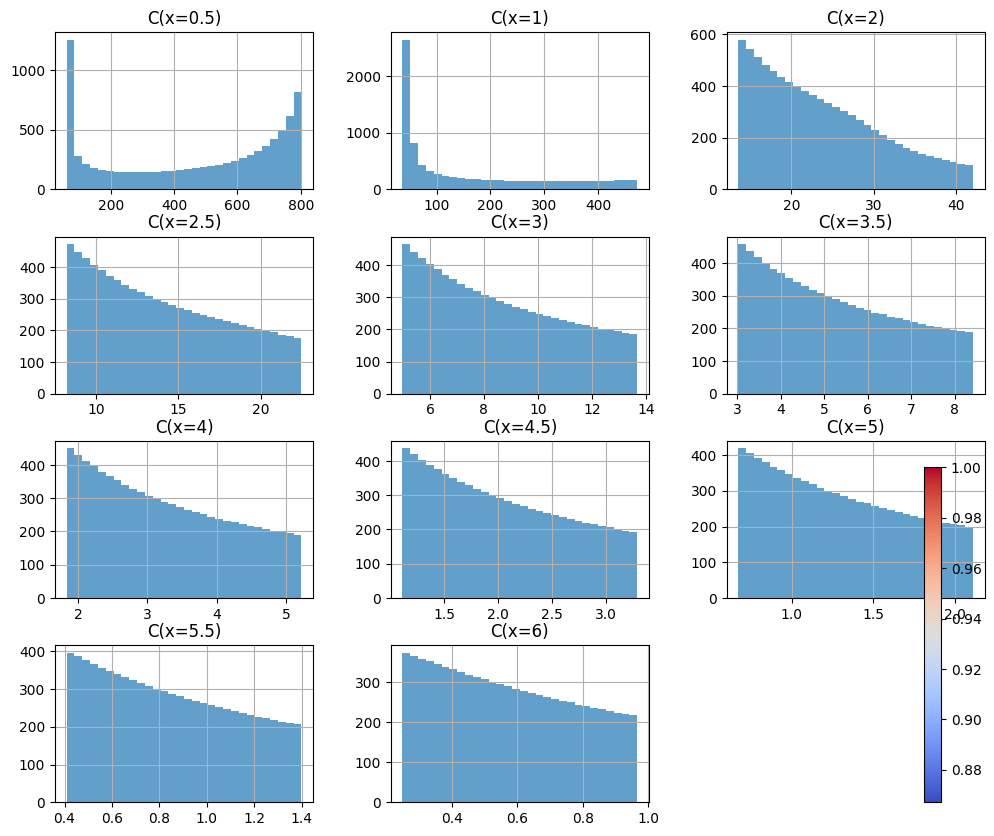

In [ ]:
# =========================
# قراءة الداتا بالكامل
# =========================
df = pd.read_csv("C_vs_t_multi_x_50000.csv")

# كل الأعمدة بعد الت هي الهدف — تلقائيًا
target_cols = df.columns[1:]

# =========================
#  التحقق من جودة البيانات
# =========================
print("\n التحقق من جودة البيانات:")
print(f" شكل البيانات: {df.shape}")
print(df.info())
print("\n القيم المفقودة:")
print(df.isnull().sum())
print("\n الإحصائيات الوصفية:")
print(df.describe())


# =========================
# تنظيف البيانات (نسخة جديدة متوافقة مع target_cols)
# =========================
def clean_data(df, target_cols):
    df_clean = df.copy()

    print(f"\n عدد القيم المفقودة قبل التنظيف: {df_clean.isnull().sum().sum()}")

    # إزالة الصفوف التي تحتوي على قيم مفقودة في الأعمدة المستهدفة
    df_clean = df_clean.dropna(subset=target_cols)

    # إزالة القيم السالبة لو غير منطقية
    for col in target_cols:
        df_clean = df_clean[df_clean[col] >= 0]

    print(f" عدد القيم المفقودة بعد التنظيف: {df_clean.isnull().sum().sum()}")
    print(f" شكل البيانات بعد التنظيف: {df_clean.shape}")

    return df_clean

df_clean = clean_data(df, target_cols)


# =========================
# التحليل الاستكشافي (يتعامل تلقائيًا مع أي عدد أعمدة)
# =========================
def exploratory_analysis(df_clean, target_cols):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Scatter لكل عمود مستهدف
    for col in target_cols:
        axes[0,0].scatter(df_clean['t'], df_clean[col], alpha=0.5, s=10, label=col)

    axes[0,0].set_title("توزيع البيانات بعد التنظيف")
    axes[0,0].set_xlabel("t")
    axes[0,0].set_ylabel("C values")
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Boxplot
    df_clean[target_cols].boxplot(ax=axes[0,1])
    axes[0,1].set_title("المخططات الصندوقية")

    # Histogram
    df_clean[target_cols].hist(ax=axes[1,0], bins=30, alpha=0.7)
    axes[1,0].set_title("التوزيع")

    # Correlation matrix
    corr_matrix = df_clean.corr()
    im = axes[1,1].imshow(corr_matrix.values, cmap='coolwarm', aspect='auto')
    axes[1,1].set_xticks(range(len(corr_matrix.columns)))
    axes[1,1].set_yticks(range(len(corr_matrix.columns)))
    axes[1,1].set_xticklabels(corr_matrix.columns, rotation=45)
    axes[1,1].set_yticklabels(corr_matrix.columns)
    plt.colorbar(im, ax=axes[1,1])
    axes[1,1].set_title("مصفوفة الارتباط")

    # أرقام الارتباط داخل المصفوفة
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            axes[1,1].text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                           ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

exploratory_analysis(df_clean, target_cols)


# =========================
# تجهيز X و y لباقي الخوارزميات
# =========================
X = df_clean[['t']].values
y = df_clean[target_cols].values

# قيم مفقودة بعد التنظيف؟
if np.isnan(y).sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    y = imputer.fit_transform(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
# =========================
# تقسيم Train إلى Train + Validation
# =========================

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train_scaled,
    test_size=0.2,   # نسبة الفاليديشن من الداتا التدريبية
    random_state=42,
    shuffle=True
)

print("\n أحجام البيانات بعد التقسيم:")
print("X_train_final:", X_train_final.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test_scaled.shape)



 أحجام البيانات بعد التقسيم:
X_train_final: (5496, 1)
X_val: (1375, 1)
X_test: (1718, 1)


In [ ]:
# THIS CELL IS NOT IMPORTANT. IT WAS JUST DONE TO CALCULATE THE CORRECT MEAN OF
# Assuming your dataframe is named df_clean as per the notebook

correct_mean = y_test.mean()
print(f"The correct mean for SI calculation is: {correct_mean}")

# Then use your known RMSE
manual_si = 0.000102 / correct_mean
print(f"Corrected Scatter Index: {manual_si}")

The correct mean for SI calculation is: 61.87846200153208
Corrected Scatter Index: 1.64839261837947e-06


In [ ]:
# =========================
# تعريف المقاييس (Metrics)
# =========================

def correlation_coefficient(y_true, y_pred):
    """معامل الارتباط"""
    return np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

def scatter_index(y_true, y_pred):
    """Scatter Index"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mean_true = np.mean(y_true)
    return rmse / mean_true

def willmott_index(y_true, y_pred):
    """Willmott Index"""
    mean_true = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true))**2)
    return 1 - numerator / denominator

def evaluate_model(y_true, y_pred):
    """إرجاع كل المقاييس دفعة واحدة"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    cc = correlation_coefficient(y_true, y_pred)
    si = scatter_index(y_true, y_pred)
    wi = willmott_index(y_true, y_pred)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "CC": cc,
        "SI": si,
        "WI": wi
    }


In [ ]:

# =========================
# تعريف النماذج التقليدية
# ========================ماذج
from sklearn.linear_model import LinearRegression
models = {
    "Linear Regression": LinearRegression(),
    #"KNN": KNeighborsRegressor(n_neighbors=1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
   # "Bagged Model": BaggingRegressor(RandomForestRegressor(), n_estimators=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVM (RBF Kernel)": SVR(kernel='rbf', C=10),
    "Linear SVM": LinearSVR(random_state=42, max_iter=5000),
   # "Ridge Regression": Ridge(alpha=1.0),
    #"MLP (Shallow)": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42),
    "MLP ": MLPRegressor(hidden_layer_sizes=(100,100,50), max_iter=2000, random_state=42),
  #  "Deep MLP Extra": MLPRegressor(hidden_layer_sizes=(200,150,100,50), max_iter=3000, random_state=42)
}


In [ ]:

results = []

# النماذج التي تحتاج MultiOutputRegressor
single_output_models_names = ["Gradient Boosting", "SVM (RBF Kernel)", "Linear SVM"]

for name, model in models.items():
    print(f"Training {name}...")
    start_train = time.time()

    current_model = model
    # تغليف النماذج أحادية المخرجات
    if name in single_output_models_names:
        current_model = MultiOutputRegressor(model)

    current_model.fit(X_train_final, y_train_final)
    train_time = time.time() - start_train

    start_pred = time.time()
    # التنبؤ على validation
    y_val_pred = current_model.predict(X_val)
    # التنبؤ على test
    y_test_pred = current_model.predict(X_test_scaled)
    pred_time = time.time() - start_pred

    # تحويل القيم للعادية
    y_val_true = scaler_y.inverse_transform(y_val)
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    y_test_true = scaler_y.inverse_transform(y_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)

    val_metrics = evaluate_model(y_val_true, y_val_pred)
    test_metrics = evaluate_model(y_test_true, y_test_pred)

    results.append({
        "Model": name,
        "Validation MSE": val_metrics["MSE"],
        "Validation MAE": val_metrics["MAE"],
        "Validation RMSE": val_metrics["RMSE"],
        "Validation R²": val_metrics["R²"],
        "Validation CC": val_metrics["CC"],
        "Validation SI": val_metrics["SI"],
        "Validation WI": val_metrics["WI"],
        "Test MSE": test_metrics["MSE"],
        "Test MAE": test_metrics["MAE"],
        "Test RMSE": test_metrics["RMSE"],
        "Test R²": test_metrics["R²"],
        "Test CC": test_metrics["CC"],
        "Test SI": test_metrics["SI"],
        "Test WI": test_metrics["WI"],
        "Train Time": train_time,
        "Pred Time": pred_time
    })

# =========================
# تحويل النتائج ل DataFrame وعرضها
# =========================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test R²", ascending=False)
print("\n===================جدول مقارنة النماذج ===================")
print(results_df.to_string(index=False))

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF Kernel)...
Training Linear SVM...
Training MLP ...

===================جدول مقارنة النماذج ===================
            Model  Validation MSE  Validation MAE  Validation RMSE  Validation R²  Validation CC  Validation SI  Validation WI   Test MSE  Test MAE  Test RMSE  Test R²  Test CC  Test SI  Test WI  Train Time  Pred Time
    Random Forest        0.000884        0.008798         0.029737       1.000000       1.000000       0.000471       1.000000   0.000804  0.008421   0.028355 1.000000 1.000000 0.000458 1.000000    1.414110   0.110920
             MLP         0.379911        0.192731         0.616369       0.999961       0.999993       0.009752       0.999996   0.406166  0.195189   0.637312 0.999961 0.999992 0.010299 0.999996    1.331339   0.013850
Gradient Boosting        0.237626        0.146337         0.487469       0.999954       0.999996       0.007713       0.999998   0.

In [ ]:
# =========================================
# إعداد بيانات النماذج العميقة (Multi-Output)
# =========================================

# استخدام نفس بيانات التدريب بعد التقسيم النهائي
X_train_dl = X_train_final.reshape((X_train_final.shape[0], 1, X_train_final.shape[1]))
X_val_dl   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_dl  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

n_outputs = y_train_final.shape[1]  # عدد الـ targets

# Early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

results_dl = []

# =========================================
# دالة التقييم الموحدة للنماذج العميقة
# =========================================
def evaluate_dl(model, X_train_dl, y_train_s,
                X_val_dl, y_val_s,
                X_test_dl, y_test_s,
                name):

    start_train = time.time()
    history = model.fit(
        X_train_dl,
        y_train_s,
        validation_data=(X_val_dl, y_val_s),
        epochs=200,
        callbacks=[es],
        verbose=0
    )
    train_time = time.time() - start_train

    start_pred = time.time()
    y_val_pred_s  = model.predict(X_val_dl)
    y_test_pred_s = model.predict(X_test_dl)
    pred_time = time.time() - start_pred

    # =====================
    # Inverse scaling
    # =====================
    y_val_true  = scaler_y.inverse_transform(y_val_s)
    y_val_pred  = scaler_y.inverse_transform(y_val_pred_s)

    y_test_true = scaler_y.inverse_transform(y_test_s)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_s)

    val_metrics  = evaluate_model(y_val_true, y_val_pred)
    test_metrics = evaluate_model(y_test_true, y_test_pred)

    results_dl.append({
        "Model": name,
        "Validation MSE": val_metrics["MSE"],
        "Validation MAE": val_metrics["MAE"],
        "Validation RMSE": val_metrics["RMSE"],
        "Validation R²": val_metrics["R²"],
        "Validation CC": val_metrics["CC"],
        "Validation SI": val_metrics["SI"],
        "Validation WI": val_metrics["WI"],
        "Test MSE": test_metrics["MSE"],
        "Test MAE": test_metrics["MAE"],
        "Test RMSE": test_metrics["RMSE"],
        "Test R²": test_metrics["R²"],
        "Test CC": test_metrics["CC"],
        "Test SI": test_metrics["SI"],
        "Test WI": test_metrics["WI"],
        "Train Time": train_time,
        "Pred Time": pred_time
    })

    print(f" {name} finished | Val RMSE = {val_metrics['RMSE']:.4f}")
    return history


# =========================================
# LSTM
# =========================================
lstm = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    LSTM(50),
    Dense(n_outputs)
])
lstm.compile(optimizer='adam', loss='mse')

hist_lstm = evaluate_dl(
    lstm,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "LSTM"
)

# =========================================
# GRU
# =========================================
gru = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    GRU(50),
    Dense(n_outputs)
])
gru.compile(optimizer='adam', loss='mse')

hist_gru = evaluate_dl(
    gru,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "GRU"
)

# =========================================
# BiLSTM
# =========================================
bilstm = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    Bidirectional(LSTM(50)),
    Dense(n_outputs)
])
bilstm.compile(optimizer='adam', loss='mse')

hist_bilstm = evaluate_dl(
    bilstm,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "BiLSTM"
)

# =========================================
# Hybrid Model (Random Forest + MLP Residual)
# =========================================


# =========================
# تدريب Random Forest على كل الأعمدة
# =========================
start_train_rf = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train_final)  # multi-output
rf_train_time = time.time() - start_train_rf

# =========================
# حساب residuals لكل عمود هدف
# =========================
rf_pred_train = rf.predict(X_train_final)
residuals_train = y_train_final - rf_pred_train

# =========================
# Scale residuals
# =========================
scaler_res = StandardScaler()
residuals_train_scaled = scaler_res.fit_transform(residuals_train)

# =========================
# تدريب MLP على residuals (multi-output)
# =========================
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
mlp_multi = MultiOutputRegressor(mlp)

start_train_mlp = time.time()
mlp_multi.fit(X_train_final, residuals_train_scaled)
mlp_train_time = time.time() - start_train_mlp

# =========================
# توقع على Validation و Test مع الوقت الفعلي
# =========================
start_pred = time.time()
rf_pred_val  = rf.predict(X_val)
rf_pred_test = rf.predict(X_test_scaled)

residual_val_scaled  = mlp_multi.predict(X_val)
residual_test_scaled = mlp_multi.predict(X_test_scaled)
pred_time = time.time() - start_pred

# Inverse scale residuals
residual_val  = scaler_res.inverse_transform(residual_val_scaled)
residual_test = scaler_res.inverse_transform(residual_test_scaled)

# Hybrid prediction النهائي
hybrid_val_pred  = scaler_y.inverse_transform(rf_pred_val  + residual_val)
hybrid_test_pred = scaler_y.inverse_transform(rf_pred_test + residual_test)

# =========================
# تقييم Hybrid
# =========================
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    cc = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]
    si = rmse / np.mean(y_true)
    mean_true = np.mean(y_true)
    wi = 1 - np.sum((y_true - y_pred)**2) / np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true))**2)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "CC": cc,
        "SI": si,
        "WI": wi
    }

val_metrics  = evaluate_model(scaler_y.inverse_transform(y_val), hybrid_val_pred)
test_metrics = evaluate_model(scaler_y.inverse_transform(y_test_scaled), hybrid_test_pred)

# =========================
# حفظ النتائج مع الوقت الفعلي
# =========================
results_dl.append({
    "Model": "Hybrid RF + MLP (Residual) Corrected",
    "Validation MSE": val_metrics["MSE"],
    "Validation MAE": val_metrics["MAE"],
    "Validation RMSE": val_metrics["RMSE"],
    "Validation R²": val_metrics["R²"],
    "Validation CC": val_metrics["CC"],
    "Validation SI": val_metrics["SI"],
    "Validation WI": val_metrics["WI"],
    "Test MSE": test_metrics["MSE"],
    "Test MAE": test_metrics["MAE"],
    "Test RMSE": test_metrics["RMSE"],
    "Test R²": test_metrics["R²"],
    "Test CC": test_metrics["CC"],
    "Test SI": test_metrics["SI"],
    "Test WI": test_metrics["WI"],
    "Train Time": rf_train_time + mlp_train_time,
    "Pred Time": pred_time
})


print(" Hybrid RF + MLP (Residual) Corrected finished")


# =========================================
# جدول النتائج النهائي
# =========================================
results_dl_df = pd.DataFrame(results_dl)
results_dl_df = results_dl_df.sort_values("Test R²", ascending=False)

print("\n Deep Learning & Hybrid Results:")
print(results_dl_df.to_string(index=False))


In [ ]:
# إضافة النموذج الهجين لقاموس models
models["Hybrid RF + MLP (Residual) Corrected"] = {
    "rf": rf,
    "mlp": mlp,
    "scaler_res": scaler_res
}

print(" تم إضافة Hybrid RF + MLP (Residual) Corrected إلى قاموس models")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# رسم Validation Loss لكل الموديلات العميقة
# =========================
def plot_val_loss(histories, model_names):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss (MSE)')
    plt.title('Validation Loss for Deep Learning Models')
    plt.legend()
    plt.grid(True)
    plt.show()

# استخدمنا القيم اللي خزنتها من hist_lstm, hist_gru, hist_bilstm
plot_val_loss([hist_lstm, hist_gru, hist_bilstm], ['LSTM', 'GRU', 'BiLSTM'])

# =========================
#  رسم RMSE لكل Target لكل موديل (Deep + Hybrid)
# =========================
def plot_rmse_per_target(y_true_dict, y_pred_dict, model_names):
    n_targets = y_true_dict[model_names[0]].shape[1]
    x = np.arange(1, n_targets+1)

    plt.figure(figsize=(12,6))
    for name in model_names:
        rmse_values = [np.sqrt(mean_squared_error(y_true_dict[name][:,i], y_pred_dict[name][:,i]))
                       for i in range(n_targets)]
        plt.plot(x, rmse_values, marker='o', label=name)

    plt.xlabel('Target index')
    plt.ylabel('RMSE')
    plt.title('RMSE per Target for Deep Learning and Hybrid Models')
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()

# =========================
# تحضير البيانات
# =========================
hybrid_pred = hybrid_test_pred
y_true_dict = {
    'LSTM': y_test,
    'GRU': y_test,
    'BiLSTM': y_test,
    'Hybrid RF+MLP': y_test
}

y_pred_dict = {
    'LSTM': lstm.predict(X_test_dl),
    'GRU': gru.predict(X_test_dl),
    'BiLSTM': bilstm.predict(X_test_dl),
    'Hybrid RF+MLP': hybrid_pred
}

plot_rmse_per_target(y_true_dict, y_pred_dict, ['LSTM','GRU','BiLSTM','Hybrid RF+MLP'])


In [ ]:
print("Columns in results_df:", results_df.columns.tolist())
print("Columns in results_dl_df:", results_dl_df.columns.tolist())


In [ ]:
# =========================
# دمج جداول التقليدية والعميقة/Hybrid مع جميع الأعمدة
# =========================

# نسخ الجداول
df_trad_full = results_df.copy()
df_deep_full = results_dl_df.drop(columns=['History'], errors='ignore').copy()  # نحذف عمود History لو موجود

# دمج الجداول
comparison_full_df = pd.concat([df_trad_full, df_deep_full], ignore_index=True)

# ترتيب حسب Test RMSE تصاعديًا (الأفضل أولًا)
comparison_full_df = comparison_full_df.sort_values(by='Test RMSE', ascending=True).reset_index(drop=True)

print("\nجدول مقارنة شامل بكل الأعمدة بين التقليدية والعميقة/Hybrid:")
print(comparison_full_df)

# =========================
# اختيار أفضل موديل
# =========================
best_model_row = comparison_full_df.iloc[0]
print(f"\n أفضل موديل حسب RMSE: {best_model_row['Model']} | RMSE = {best_model_row['Test RMSE']:.4f}, R² = {best_model_row['Test R²']:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# =========================
# X كامل (Train + Test)
# =========================
X_full = np.vstack([X_train_final, X_test_scaled])

# t الحقيقي
t_full = scaler_X.inverse_transform(X_full)[:, 0]

# y الحقيقي
y_true_full = np.vstack([y_train_final, y_test_scaled])
y_true_full = scaler_y.inverse_transform(y_true_full)

# =========================
# Hybrid Prediction (الصحيح)
# =========================
rf_pred_full = rf.predict(X_full)

# ✅ MLP يأخذ X_full (مش rf_pred)
residual_full_scaled = mlp_multi.predict(X_full)
residual_full = scaler_res.inverse_transform(residual_full_scaled)

y_pred_full = rf_pred_full + residual_full

# =========================
# ترتيب حسب t
# =========================
idx = np.argsort(t_full)
t_sorted = t_full[idx]

# =========================
# رسم المنحنيات
# =========================
n_targets = y_true_full.shape[1]
plt.figure(figsize=(12,6))
colors = plt.cm.get_cmap('tab10', n_targets)

t_smooth = np.linspace(t_sorted.min(), t_sorted.max(), 2000)

for i in range(n_targets):

    # True
    y_true_sorted = y_true_full[idx, i]
    spline_true = make_interp_spline(t_sorted, y_true_sorted)
    y_true_smooth = spline_true(t_smooth)

    plt.plot(
        t_smooth, y_true_smooth,
        color=colors(i), alpha=0.4,
        label=f'True C{i+1}'
    )

    # Predicted
    y_pred_sorted = y_pred_full[idx, i]
    spline_pred = make_interp_spline(t_sorted, y_pred_sorted)
    y_pred_smooth = spline_pred(t_smooth)

    plt.plot(
        t_smooth, y_pred_smooth,
        linestyle='--', linewidth=2,
        color=colors(i),
        label=f'Pred C{i+1}'
    )

plt.xlabel('t')
plt.ylabel('C')
plt.title('Hybrid RF + MLP (Residual) — t vs C')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 # ======================
# التنبؤ عند قيم جديدة من t (FINAL VERSION)
# ======================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# ======================
# تجهيز بيانات جديدة بنفس شكل X_train
# ======================
t_new = np.zeros((50000, X_train.shape[1]))   # نفس عدد الـ features
t_new[:, 0] = np.linspace(0, 17.5, 50000)      # t هو العمود الأول

# استخدام نفس scaler الخاص بـ X
t_new_scaled = scaler_X.transform(t_new)

# ======================
# اختيار أفضل موديل
# ======================
best_model_name = best_model_row['Model']
print(f" Using best model: {best_model_name}")

# ======================
# التنبؤ حسب نوع النموذج
# ======================

# -------- Hybrid RF + MLP --------
if best_model_name == "Hybrid RF + MLP (Residual) Corrected":

    #  توقعات RF على t_new_scaled
    rf_pred = rf.predict(t_new_scaled)

   # إذا كانت المخرجات متعددة، نتأكد من استخدام MultiOutputRegressor للـ MLP
    if y_train.shape[1] > 1:
        mlp_multi = MultiOutputRegressor(mlp)
        mlp_multi.fit(rf.predict(X_train_scaled), y_train - rf.predict(X_train_scaled))
        residual = mlp_multi.predict(rf_pred)
    else:
        residual = mlp.predict(rf_pred.reshape(-1, 1))

    #  جمع RF + residual للحصول على التوقع النهائي
    y_new_pred = rf_pred + residual

# -------- Deep Learning Models --------
elif best_model_name in ["LSTM", "GRU", "BiLSTM"]:

    t_new_dl = t_new_scaled.reshape(
        (t_new_scaled.shape[0], t_new_scaled.shape[1], 1)
    )

    if best_model_name == "LSTM":
        y_new_pred = lstm.predict(t_new_dl)
    elif best_model_name == "GRU":
        y_new_pred = gru.predict(t_new_dl)
    elif best_model_name == "BiLSTM":
        y_new_pred = bilstm.predict(t_new_dl)

# -------- Traditional ML Models --------
elif best_model_name in models:

    y_new_pred_scaled = models[best_model_name].predict(t_new_scaled)
    y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

else:
    raise ValueError(f" Model {best_model_name} not supported")

# ======================
# الرسم
# ======================
plt.figure(figsize=(10,5))
plt.plot(t_new[:, 0], y_new_pred, linewidth=2)
plt.xlabel('t')
plt.ylabel('Predicted Outputs')
plt.title(f'Future Prediction using {best_model_name}')
plt.grid(True)
plt.show()


In [ ]:
# Add this code after training all models (after the comparison_full_df section)

import pickle
import os
from datetime import datetime

# Create directories for saving
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"model_results_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

models_dir = os.path.join(save_dir, "models")
data_dir = os.path.join(save_dir, "data")
predictions_dir = os.path.join(save_dir, "predictions")

os.makedirs(models_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)

print(f"\n✓ Created directory structure: {save_dir}")

# =========================
# 1. Save Train/Val/Test Data as CSV
# =========================

# Convert scaled data back to original scale
X_train_original = scaler_X.inverse_transform(X_train_final)
X_val_original = scaler_X.inverse_transform(X_val)
X_test_original = scaler_X.inverse_transform(X_test_scaled)

y_train_original = scaler_y.inverse_transform(y_train_final)
y_val_original = scaler_y.inverse_transform(y_val)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Create DataFrames with proper column names
train_df = pd.DataFrame(
    np.hstack([X_train_original, y_train_original]),
    columns=['t'] + list(target_cols)
)
val_df = pd.DataFrame(
    np.hstack([X_val_original, y_val_original]),
    columns=['t'] + list(target_cols)
)
test_df = pd.DataFrame(
    np.hstack([X_test_original, y_test_original]),
    columns=['t'] + list(target_cols)
)

# Save to CSV
train_df.to_csv(os.path.join(data_dir, "train_data.csv"), index=False)
val_df.to_csv(os.path.join(data_dir, "validation_data.csv"), index=False)
test_df.to_csv(os.path.join(data_dir, "test_data.csv"), index=False)

print(f"✓ Saved train/validation/test data to {data_dir}")

# =========================
# 2. Save All ML Models
# =========================

# Save traditional ML models
for name, model in models.items():
    if name == "Hybrid RF + MLP (Residual) Corrected":
        # Save hybrid model components
        hybrid_dict = {
            'rf': model['rf'],
            'mlp': model['mlp'],
            'scaler_res': model['scaler_res']
        }
        with open(os.path.join(models_dir, f"{name.replace(' ', '_')}.pkl"), 'wb') as f:
            pickle.dump(hybrid_dict, f)
    else:
        # Save regular models
        with open(os.path.join(models_dir, f"{name.replace(' ', '_')}.pkl"), 'wb') as f:
            pickle.dump(model, f)

# Save deep learning models
lstm.save(os.path.join(models_dir, "LSTM.h5"))
gru.save(os.path.join(models_dir, "GRU.h5"))
bilstm.save(os.path.join(models_dir, "BiLSTM.h5"))

# Save scalers (essential for loading models later)
with open(os.path.join(models_dir, "scaler_X.pkl"), 'wb') as f:
    pickle.dump(scaler_X, f)
with open(os.path.join(models_dir, "scaler_y.pkl"), 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"✓ Saved all models to {models_dir}")

# =========================
# 3. Generate and Save Predictions for All Models
# =========================

def save_predictions(model, model_name, X_val_input, X_test_input, is_dl=False):
    """Generate and save predictions for validation and test sets"""

    # Get predictions
    if is_dl:
        # Reshape for deep learning models
        X_val_dl = X_val_input.reshape((X_val_input.shape[0], 1, X_val_input.shape[1]))
        X_test_dl = X_test_input.reshape((X_test_input.shape[0], 1, X_test_input.shape[1]))

        val_pred_scaled = model.predict(X_val_dl)
        test_pred_scaled = model.predict(X_test_dl)
    elif model_name == "Hybrid RF + MLP (Residual) Corrected":
        # Hybrid model prediction
        rf_pred_val = model['rf'].predict(X_val_input)
        rf_pred_test = model['rf'].predict(X_test_input)

        residual_val_scaled = model['mlp'].predict(X_val_input)
        residual_test_scaled = model['mlp'].predict(X_test_input)

        residual_val = model['scaler_res'].inverse_transform(residual_val_scaled)
        residual_test = model['scaler_res'].inverse_transform(residual_test_scaled)

        val_pred_scaled = rf_pred_val + residual_val
        test_pred_scaled = rf_pred_test + residual_test
    else:
        # Traditional ML models
        val_pred_scaled = model.predict(X_val_input)
        test_pred_scaled = model.predict(X_test_input)

    # Convert to original scale
    val_pred = scaler_y.inverse_transform(val_pred_scaled)
    test_pred = scaler_y.inverse_transform(test_pred_scaled)

    # Prepare validation predictions DataFrame
    val_predictions_df = pd.DataFrame({
        't': X_val_original[:, 0]
    })

    # Add actual values
    for i, col in enumerate(target_cols):
        val_predictions_df[f'{col}_actual'] = y_val_original[:, i]

    # Add predicted values
    for i, col in enumerate(target_cols):
        val_predictions_df[f'{col}_predicted'] = val_pred[:, i]

    # Prepare test predictions DataFrame
    test_predictions_df = pd.DataFrame({
        't': X_test_original[:, 0]
    })

    # Add actual values
    for i, col in enumerate(target_cols):
        test_predictions_df[f'{col}_actual'] = y_test_original[:, i]

    # Add predicted values
    for i, col in enumerate(target_cols):
        test_predictions_df[f'{col}_predicted'] = test_pred[:, i]

    # Save to CSV
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '')
    val_predictions_df.to_csv(
        os.path.join(predictions_dir, f"{safe_name}_validation_predictions.csv"),
        index=False
    )
    test_predictions_df.to_csv(
        os.path.join(predictions_dir, f"{safe_name}_test_predictions.csv"),
        index=False
    )

    return val_pred, test_pred

# Save predictions for all traditional ML models
for name, model in models.items():
    if name != "Hybrid RF + MLP (Residual) Corrected":
        print(f"Saving predictions for {name}...")
        save_predictions(model, name, X_val, X_test_scaled)

# Save predictions for Hybrid model
print("Saving predictions for Hybrid RF + MLP (Residual) Corrected...")
save_predictions(
    models["Hybrid RF + MLP (Residual) Corrected"],
    "Hybrid RF + MLP (Residual) Corrected",
    X_val,
    X_test_scaled
)

# Save predictions for deep learning models
print("Saving predictions for LSTM...")
save_predictions(lstm, "LSTM", X_val, X_test_scaled, is_dl=True)

print("Saving predictions for GRU...")
save_predictions(gru, "GRU", X_val, X_test_scaled, is_dl=True)

print("Saving predictions for BiLSTM...")
save_predictions(bilstm, "BiLSTM", X_val, X_test_scaled, is_dl=True)

print(f"\n✓ Saved all predictions to {predictions_dir}")

# =========================
# 4. Save Comparison Results
# =========================

comparison_full_df.to_csv(
    os.path.join(save_dir, "model_comparison_results.csv"),
    index=False
)

print(f"✓ Saved comparison results to {save_dir}")

# =========================
# 5. Create Summary Report
# =========================

summary = f"""
Model Training and Evaluation Summary
{'='*60}

Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Dataset Information:
- Total samples: {len(df_clean)}
- Training samples: {len(X_train_final)}
- Validation samples: {len(X_val)}
- Test samples: {len(X_test_scaled)}
- Number of targets: {n_outputs}
- Target columns: {', '.join(target_cols)}

Best Model: {best_model_name}
- Test RMSE: {best_model_row['Test RMSE']:.6f}
- Test R²: {best_model_row['Test R²']:.6f}
- Test MAE: {best_model_row['Test MAE']:.6f}
- Test SI: {best_model_row['Test SI']:.6f}
- Test WI: {best_model_row['Test WI']:.6f}

Saved Files:
- Models: {models_dir}
- Data: {data_dir}
- Predictions: {predictions_dir}
- Comparison: model_comparison_results.csv

{'='*60}
"""

with open(os.path.join(save_dir, "summary_report.txt"), 'w') as f:
    f.write(summary)

print(summary)
print(f"\n✓ All files saved successfully in: {save_dir}")

# =========================
# 6. Example: How to Load Models Later
# =========================

load_example = """
# HOW TO LOAD SAVED MODELS:

import pickle
import tensorflow as tf

# Load scalers (required for all models)
with open('models/scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)
with open('models/scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Load traditional ML model
with open('models/Random_Forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Load deep learning model
lstm_model = tf.keras.models.load_model('models/LSTM.h5')

# Load hybrid model
with open('models/Hybrid_RF_+_MLP_Residual_Corrected.pkl', 'rb') as f:
    hybrid = pickle.load(f)
    rf = hybrid['rf']
    mlp = hybrid['mlp']
    scaler_res = hybrid['scaler_res']

# Make predictions
new_t = np.array([[1.5]])  # Example new input
new_t_scaled = scaler_X.transform(new_t)
prediction_scaled = rf_model.predict(new_t_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)
"""

with open(os.path.join(save_dir, "how_to_load_models.txt"), 'w') as f:
    f.write(load_example)

print("✓ Created loading instructions file")
```

This code will create a directory structure like this:
```
model_results_20250101_120000/
├── models/
│   ├── Linear_Regression.pkl
│   ├── Random_Forest.pkl
│   ├── Gradient_Boosting.pkl
│   ├── SVM_RBF_Kernel.pkl
│   ├── Linear_SVM.pkl
│   ├── MLP.pkl
│   ├── LSTM.h5
│   ├── GRU.h5
│   ├── BiLSTM.h5
│   ├── Hybrid_RF_+_MLP_Residual_Corrected.pkl
│   ├── scaler_X.pkl
│   └── scaler_y.pkl
├── data/
│   ├── train_data.csv
│   ├── validation_data.csv
│   └── test_data.csv
├── predictions/
│   ├── Linear_Regression_validation_predictions.csv
│   ├── Linear_Regression_test_predictions.csv
│   ├── Random_Forest_validation_predictions.csv
│   ├── Random_Forest_test_predictions.csv
│   └── ... (for all models)
├── model_comparison_results.csv
├── summary_report.txt
└── how_to_load_models.txt